In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-01-21 13:32:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  57.4MB/s    in 0.5s    

2023-01-21 13:32:47 (57.4 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [2]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [22]:
# 51

import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

with open('./newsCorpora.csv') as f:
   all_news = [news for news in f.readlines() if news.split('\t')[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

with open('./train.txt', mode='w') as f:
  f.writelines('\t'.join(train_data))

with open('./valid.txt', mode='w') as f:
  f.writelines('\t'.join(valid_data))

with open('./test.txt', mode='w') as f:
  f.writelines('\t'.join(test_data))

print(f'学習データ事例数: {len(train_data)}')
print(f'評価データ事例数: {len(test_data)}')

学習データ事例数: 10684
評価データ事例数: 1336


In [143]:
# 52, 53, 54, 55

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

CATEGORIES = [
    'b',
    't',
    't',
    'm'
]
SEED = 0

train_titles = np.array([news.split('\t')[1] for news in train_data])
test_titles= np.array([news.split('\t')[1] for news in test_data])
vec_tfidf = TfidfVectorizer()

Xtrain = vec_tfidf.fit_transform(train_titles)
Ytrain = [news.split('\t')[4] for news in train_data]
Xtest = vec_tfidf.transform(test_titles)
Ytest = [news.split('\t')[4] for news in test_data]

lr = LogisticRegression(random_state=SEED, n_jobs=-1)
lr.fit(Xtrain, Ytrain)

Ypred = lr.predict(Xtest)
cm = confusion_matrix(Ytest, Ypred)

print('Accuracy rate: {}'.format(sum([cm[i][i] for i in range(len(CATEGORIES))]) / np.sum(cm)))
pd.DataFrame(cm,
             columns=[f'Predicted {CATEGORY}' for CATEGORY in CATEGORIES],
             index=[f'Actual {CATEGORY}' for CATEGORY in CATEGORIES])

Accuracy rate: 0.8974550898203593


,Predicted b,Predicted t,Predicted t,Predicted m
Actual b,530,17,0,5
Actual t,11,526,0,3
Actual t,14,17,49,1
Actual m,32,36,1,94


In [144]:
# 56

row_sums = np.sum(cm, axis=0)
column_sums = np.sum(cm, axis=1)
precisions = [cm[i][i] / row_sums[i] for i in range(len(CATEGORIES))]
accuracies = [cm[i][i] / column_sums[i] for i in range(len(CATEGORIES))]
F1s = [2 * precisions[i] * accuracies[i] / (precisions[i] + accuracies[i]) for i in range(len(CATEGORIES))]

macro_prec_avg = sum(precisions) / len(CATEGORIES)
macro_acc_avg = sum(accuracies) / len(CATEGORIES)
macro_F1_avg = sum(F1s) / len(CATEGORIES)

micro_prec_avg = sum([cm[i][i] for i in range(len(CATEGORIES))]) / sum([row_sums[i] for i in range(len(CATEGORIES))])
micro_acc_avg = sum([cm[i][i] for i in range(len(CATEGORIES))]) / sum([column_sums[i] for i in range(len(CATEGORIES))])

print(f'Macro P: {macro_prec_avg}')
print(f'Macro R: {macro_acc_avg}')
print(f'Macro F1: {macro_F1_avg}')

print(f'Micro P: {micro_prec_avg}')
print(f'Micro R: {micro_acc_avg}')

Macro P: 0.9195169441413729
Macro R: 0.7789610974449155
Macro F1: 0.8278889428641221
Micro P: 0.8974550898203593
Micro R: 0.8974550898203593


In [145]:
# 57
print('Top10: {}'.format(np.sort(lr.coef_.ravel())[-10:]))
print('Worst10: {}'.format(np.sort(lr.coef_.ravel())[:10]))


Top10: [3.49235131 3.66724353 3.70717255 3.8227823  3.92070305 3.95564543
 4.53378901 4.59223362 4.82279839 5.52384357]
Worst10: [-3.53795763 -3.18704599 -2.85721777 -2.46589035 -2.44265535 -2.23527417
 -2.18246242 -2.14714795 -2.13099982 -2.09573955]


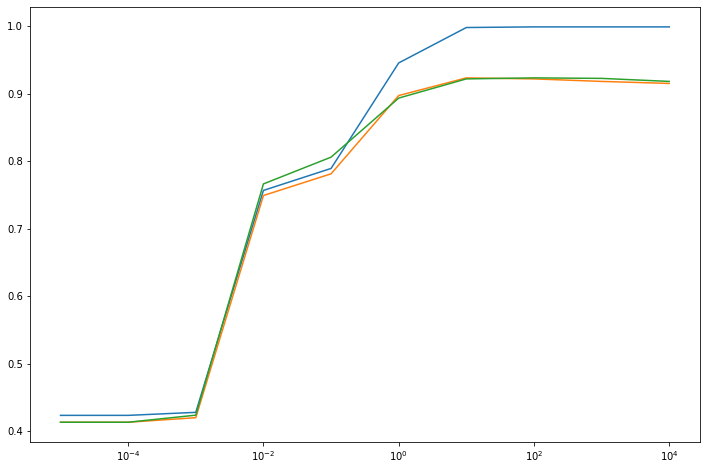

In [148]:
# 58
import matplotlib.pyplot as plt


train_titles = np.array([news.split('\t')[1] for news in train_data])
test_titles= np.array([news.split('\t')[1] for news in test_data])
valid_titles= np.array([news.split('\t')[1] for news in valid_data])
vec_tfidf = TfidfVectorizer()

Xtrain = vec_tfidf.fit_transform(train_titles)
Ytrain = [news.split('\t')[4] for news in train_data]
Xtest = vec_tfidf.transform(test_titles)
Ytest = [news.split('\t')[4] for news in test_data]
Xvalid = vec_tfidf.transform(valid_titles)
Yvalid = [news.split('\t')[4] for news in valid_data]

def training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, C):
  lr = LogisticRegression(C=C, random_state=SEED, penalty='l2', n_jobs=-1)
  lr.fit(Xtrain, Ytrain)

  r_rate_train = calculate_r_rate(lr, Xtrain, Ytrain)
  r_rate_test = calculate_r_rate(lr, Xtest, Ytest)
  r_rate_valid = calculate_r_rate(lr, Xvalid, Yvalid)
  
  return r_rate_train, r_rate_test, r_rate_valid

def calculate_r_rate(lr, X, Y):
  Ypred = lr.predict(X)
  cm = confusion_matrix(Y, Ypred)
  r_rate = sum([cm[i][i] for i in range(len(CATEGORIES))]) / np.sum(cm)
  return r_rate

regularization_strengths = [10 ** i for i in range(-5, 5)]
r_rates_train = []
r_rates_test = []
r_rates_valid = []
for i in regularization_strengths:
  r_rate_train, r_rate_test, r_rate_valid = training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, i)
  r_rates_train.append(r_rate_train)
  r_rates_test.append(r_rate_test)
  r_rates_valid.append(r_rate_valid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plt.plot(regularization_strengths, r_rates_train)
plt.plot(regularization_strengths, r_rates_test)
plt.plot(regularization_strengths, r_rates_valid)
ax.set_xscale('log')
plt.show()

In [168]:
# 59
## RandomSearch
from sklearn.model_selection import RandomizedSearchCV

estimator = LogisticRegression(random_state=SEED, n_jobs=-1)
param_distributions = {
    'C': list(range(1, 100, 10))
}
n_iter = 10
cv = 5
tuned_model = RandomizedSearchCV(estimator=estimator, 
                           param_distributions=param_distributions,
                           n_iter=n_iter, 
                           random_state=SEED,
                           cv=cv, return_train_score=False)

tuned_model.fit(Xtrain, Ytrain)


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(n_jobs=-1, random_state=0),
                   param_distributions={'C': [1, 11, 21, 31, 41, 51, 61, 71, 81,
                                              91]},
                   random_state=0)

In [171]:
best_parameter = tuned_model.best_params_['C']
print(training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, best_parameter))

(0.9991576188693373, 0.9191616766467066, 0.9214071856287425)


In [172]:
## Optuna
!pip install optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00


In [173]:
import optuna
from sklearn.model_selection import cross_val_score

      
def objective(trial, x, t, cv):
    C = trial.suggest_int('C', 1, 100)

    estimator = LogisticRegression(
      C = C,
      random_state=SEED,
      n_jobs=-1
    )

    print('Current_params : ', trial.params)
    accuracy = cross_val_score(estimator, x, t, cv=cv).mean()
    return accuracy

study = optuna.create_study(direction='maximize')
cv = 5
study.optimize(lambda trial: objective(trial, Xtrain, Ytrain, cv), n_trials=10)


[I 2023-01-21 15:56:01,034] A new study created in memory with name: no-name-43f668c2-afcc-47cb-96c0-c47d0dd88638


Current_params :  {'C': 63}


[I 2023-01-21 15:56:07,935] Trial 0 finished with value: 0.9099587874772819 and parameters: {'C': 63}. Best is trial 0 with value: 0.9099587874772819.


Current_params :  {'C': 90}


[I 2023-01-21 15:56:14,090] Trial 1 finished with value: 0.9110819886466203 and parameters: {'C': 90}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 71}


[I 2023-01-21 15:56:20,313] Trial 2 finished with value: 0.9102395110931176 and parameters: {'C': 71}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 93}


[I 2023-01-21 15:56:32,594] Trial 3 finished with value: 0.910426864641005 and parameters: {'C': 93}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 3}


[I 2023-01-21 15:56:38,648] Trial 4 finished with value: 0.8981655914430778 and parameters: {'C': 3}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 57}


[I 2023-01-21 15:56:45,710] Trial 5 finished with value: 0.9103332754973457 and parameters: {'C': 57}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 6}


[I 2023-01-21 15:56:53,584] Trial 6 finished with value: 0.9043429130760158 and parameters: {'C': 6}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 46}


[I 2023-01-21 15:56:59,537] Trial 7 finished with value: 0.9089292630818869 and parameters: {'C': 46}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 1}


[I 2023-01-21 15:57:05,751] Trial 8 finished with value: 0.874953117797886 and parameters: {'C': 1}. Best is trial 1 with value: 0.9110819886466203.


Current_params :  {'C': 36}


[I 2023-01-21 15:57:11,929] Trial 9 finished with value: 0.910052595696652 and parameters: {'C': 36}. Best is trial 1 with value: 0.9110819886466203.


In [177]:
best_parameter = study.best_params['C']
print(training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, best_parameter))

(0.9992512167727443, 0.9221556886227545, 0.9221556886227545)
